# Applying Fuzz Testing Techniques to Network-Level Auditing of Consumer IoT

In [2]:
from FlowAnalysis import NetAuditor, PolicyEvaluator
from FlowAnalysis.test import InputFuzzer
from matplotlib import pyplot as plt, ticker
from scapy.all import *
import json

%matplotlib inline

figsize = (20, 10)
plt.rcParams.update({'font.size': 24, 'lines.markersize': 10})
abs_ticker = ticker.FuncFormatter(lambda x, pos: abs(x))

First, a look at a policy defined for the handshake operation of the IDevices smart dimmer switch:

In [3]:
with open('./data/policies/Handshake.json') as f:
    handshake_policy = json.load(f)

In [4]:
handshake_policy

{'description': 'Handshake operation',
 'devices': ['192.168.42.67'],
 'flow': {'endpoints': ['192.168.42.0/24']},
 'interaction': {'max_duration': 2000,
  'max_total_payload_bytes': 4200,
  'device': {'max_single_payload_bytes': 1440, 'total_sent_bytes': 3000},
  'endpoint': {'max_single_payload_bytes': 136, 'total_sent_bytes': 1100}}}

Now to perform auditing on a valid capture and output the results:

In [5]:
pdp = PolicyEvaluator([handshake_policy])
audit = NetAuditor(pdp, './data/captures/OnlyHandShakes.json')

In [6]:
audit.flow_analyzer.get_tcp_flows()

[<Flow (192.168.42.62:53138 <--> 192.168.42.67:50008) of 68 packets>,
 <Flow (192.168.42.62:53152 <--> 192.168.42.67:50008) of 73 packets>,
 <Flow (192.168.42.62:53164 <--> 192.168.42.67:50008) of 75 packets>,
 <Flow (192.168.42.62:53172 <--> 192.168.42.67:50008) of 72 packets>,
 <Flow (192.168.42.62:53179 <--> 192.168.42.67:50008) of 73 packets>]

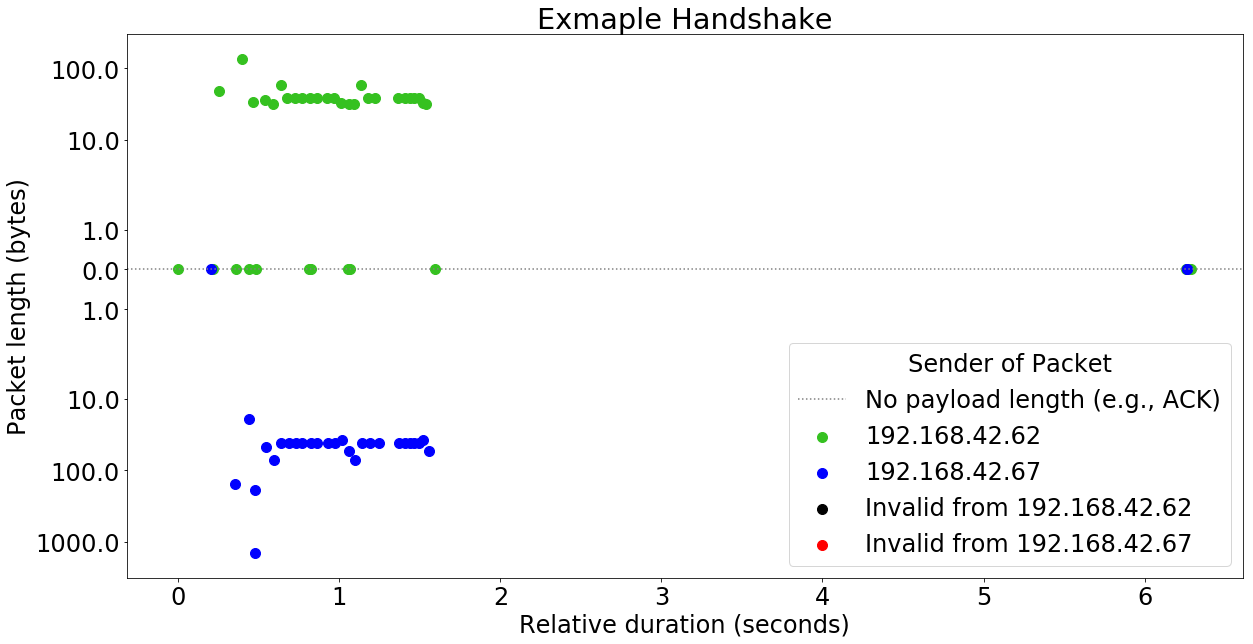

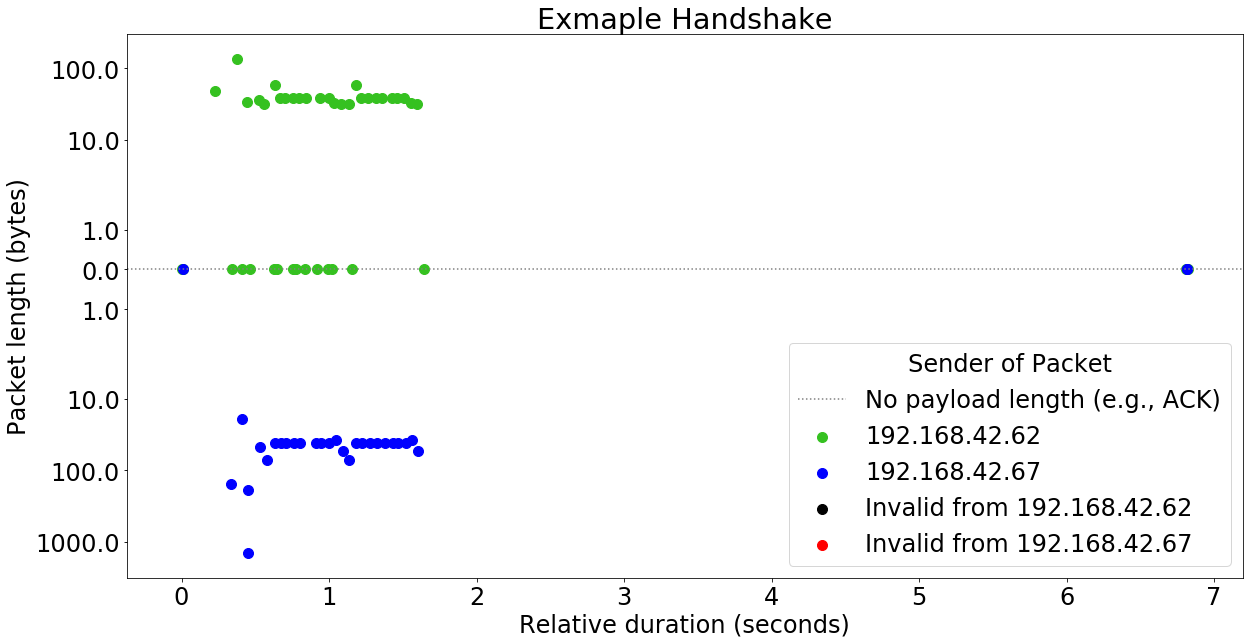

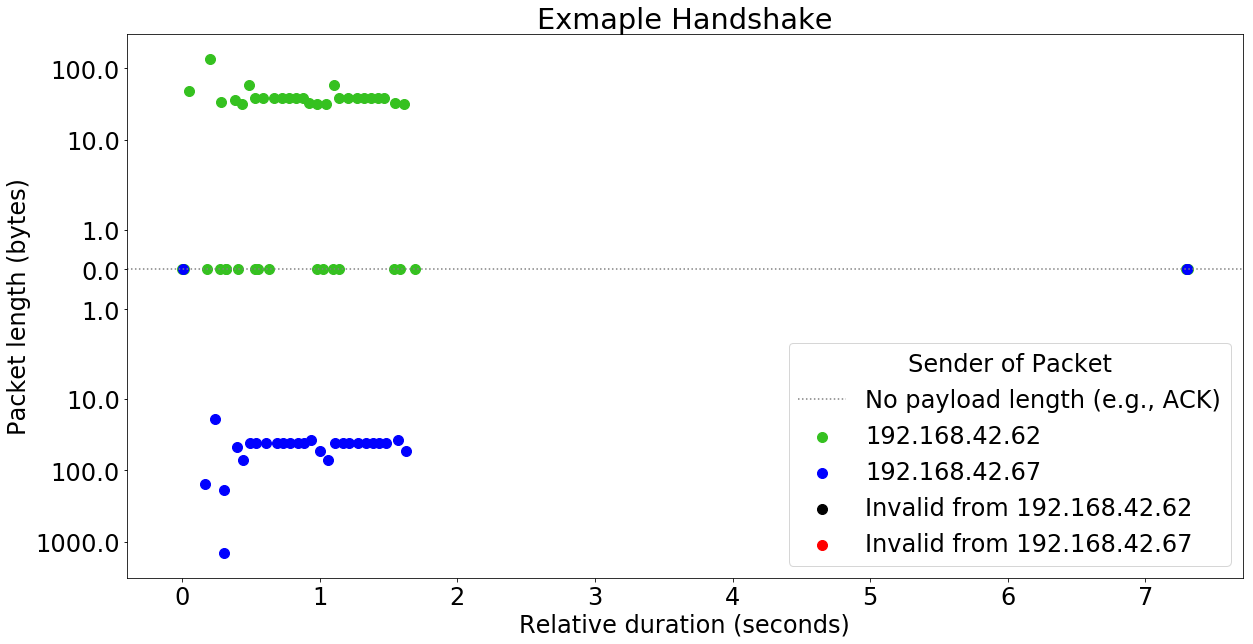

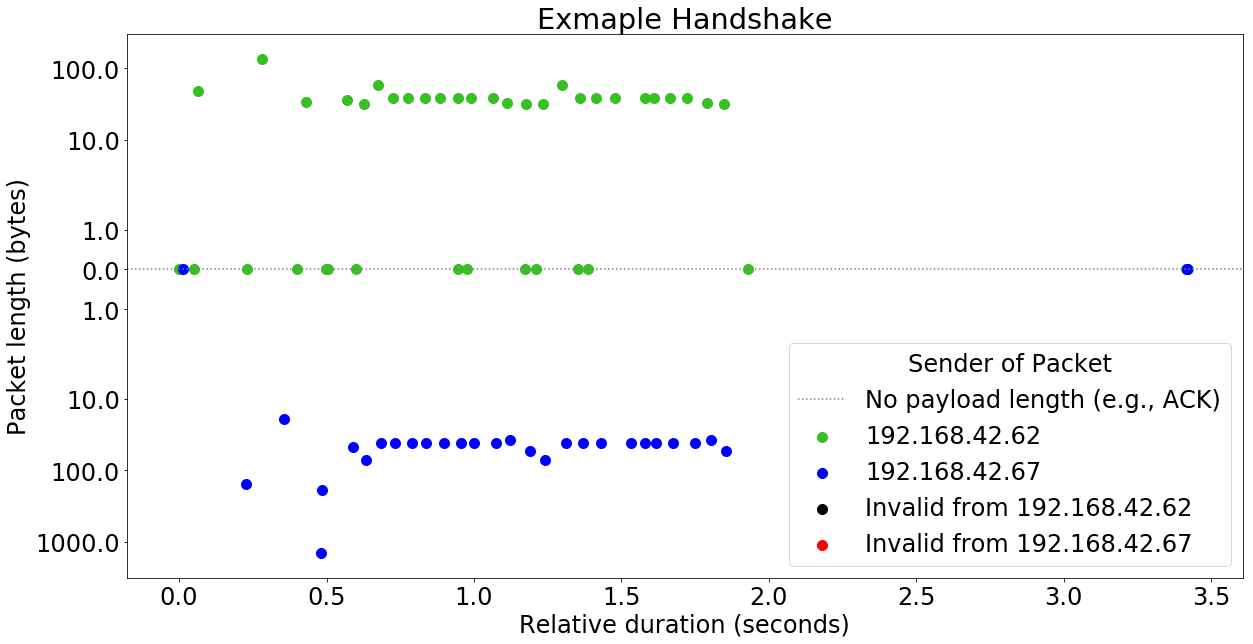

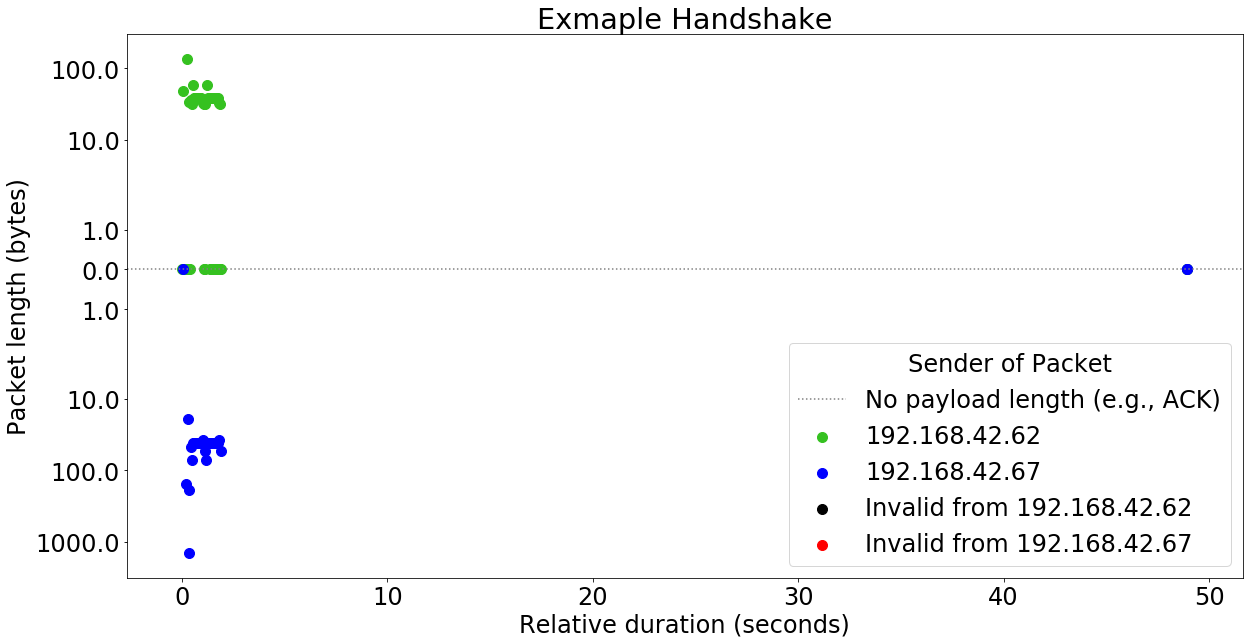

In [7]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Exmaple Handshake')
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(abs_ticker)
    plt.show()

Now for a capture that does not conform to that policy:

In [8]:
audit = NetAuditor(pdp, './data/captures/DimSlider.json')

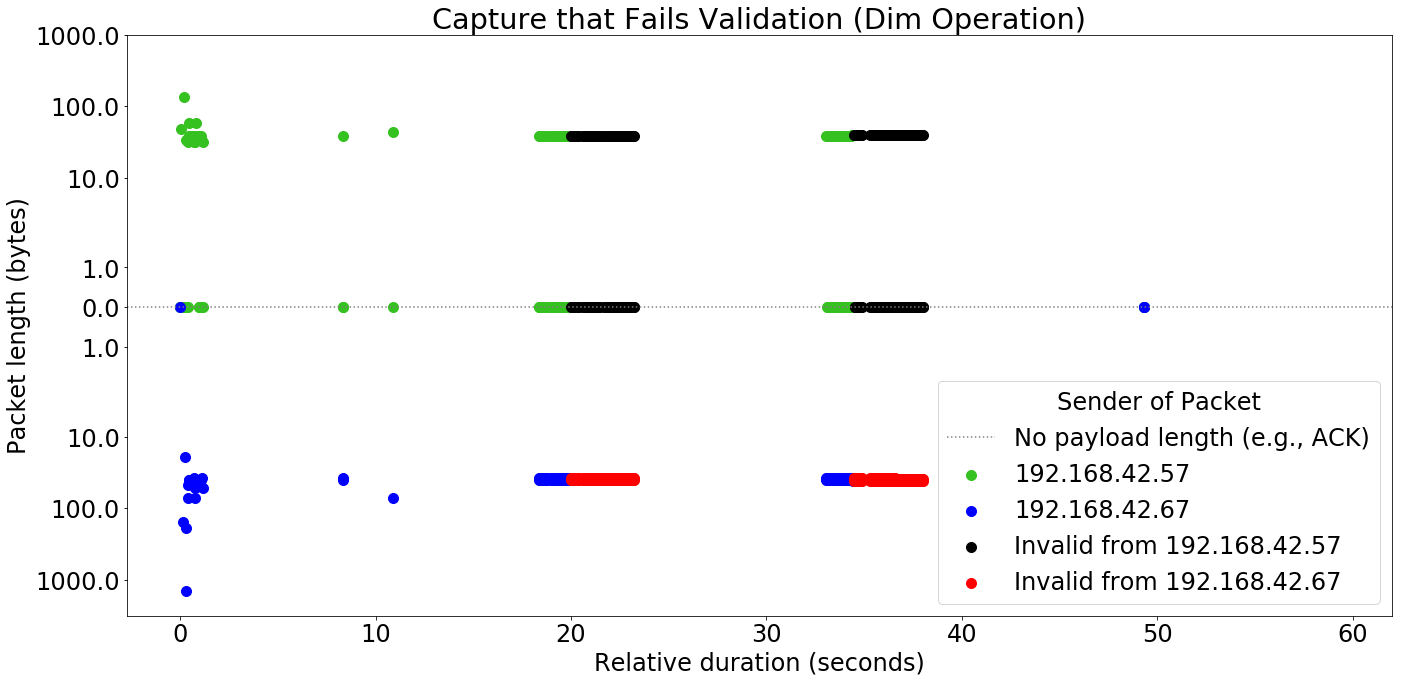

In [9]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Capture that Fails Validation (Dim Operation)')
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(abs_ticker)
    ax.set_xlim(right=62)
    ax.set_ylim(top=1000)
    fig.tight_layout()
    plt.show()

Example of use of fuzz testing:

In [10]:
fuzzer = InputFuzzer('../captures/switches/IDevicesDimmer/Handshakes/OnlyHandShakes.pcapng', handshake_policy)

In [11]:
fuzzed_packets = fuzzer.fuzz()
fuzzed_packets

Time constraint invalidated


<PacketList: TCP:575 UDP:0 ICMP:0 Other:0>

In [12]:
wrpcap('./fuzzed_packets.pcap', fuzzed_packets)

!tshark -r ./fuzzed_packets.pcap -T json > ./fuzzed_packets.json

Now we can audit the resulting packets:

In [13]:
audit = NetAuditor(pdp, './fuzzed_packets.json')

In [14]:
flows = audit.flow_analyzer.get_tcp_flows()
flows

[<Flow (192.168.42.57:53164 <--> 192.168.42.62:50008) of 298 packets>,
 <Flow (192.168.42.62:50008 <--> 192.168.42.57:53138) of 63 packets>,
 <Flow (192.168.42.57:53179 <--> 192.168.42.62:50008) of 67 packets>,
 <Flow (192.168.42.57:53152 <--> 192.168.42.62:50008) of 79 packets>,
 <Flow (192.168.42.57:53172 <--> 192.168.42.62:50008) of 60 packets>,
 <Flow (189.240.91.123:50008 <--> 192.168.42.57:53152) of 1 packets>,
 <Flow (182.104.11.232:53152 <--> 192.168.42.62:50008) of 1 packets>,
 <Flow (183.203.168.122:50008 <--> 192.168.42.57:53152) of 1 packets>,
 <Flow (179.181.129.0:53172 <--> 192.168.42.62:50008) of 1 packets>,
 <Flow (192.168.42.57:53138 <--> 206.210.245.152:50008) of 1 packets>,
 <Flow (162.178.175.202:53179 <--> 192.168.42.62:50008) of 1 packets>,
 <Flow (118.68.36.226:53179 <--> 192.168.42.62:50008) of 1 packets>,
 <Flow (152.86.31.104:53179 <--> 192.168.42.62:50008) of 1 packets>]

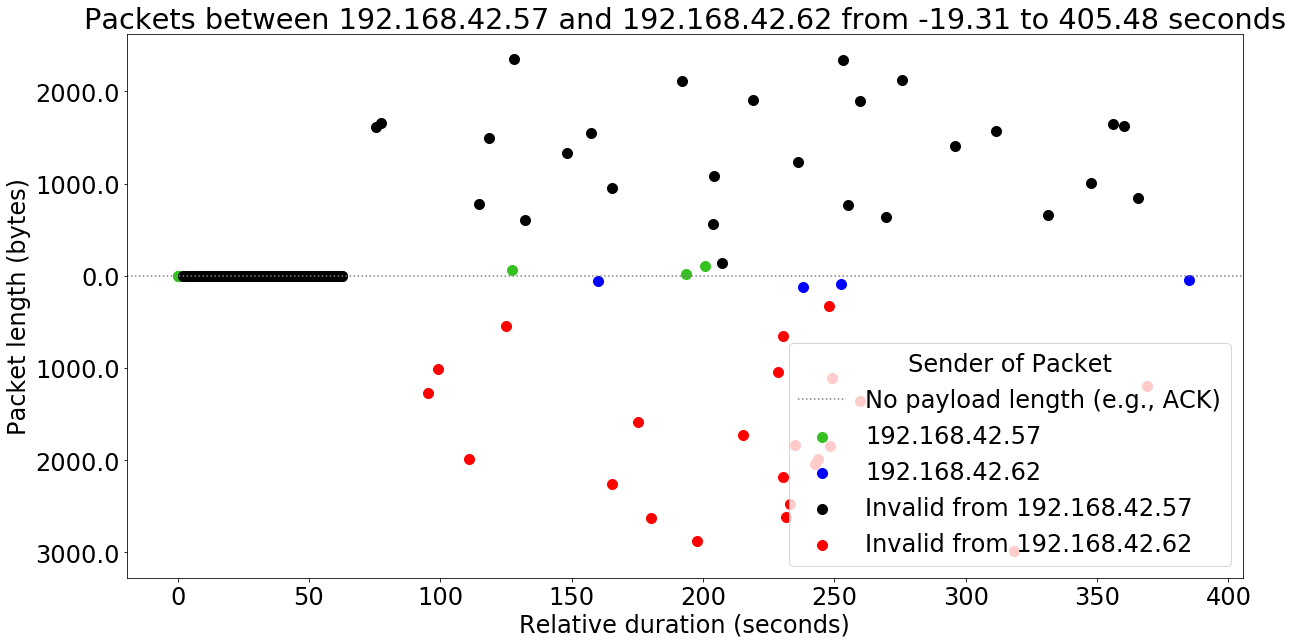

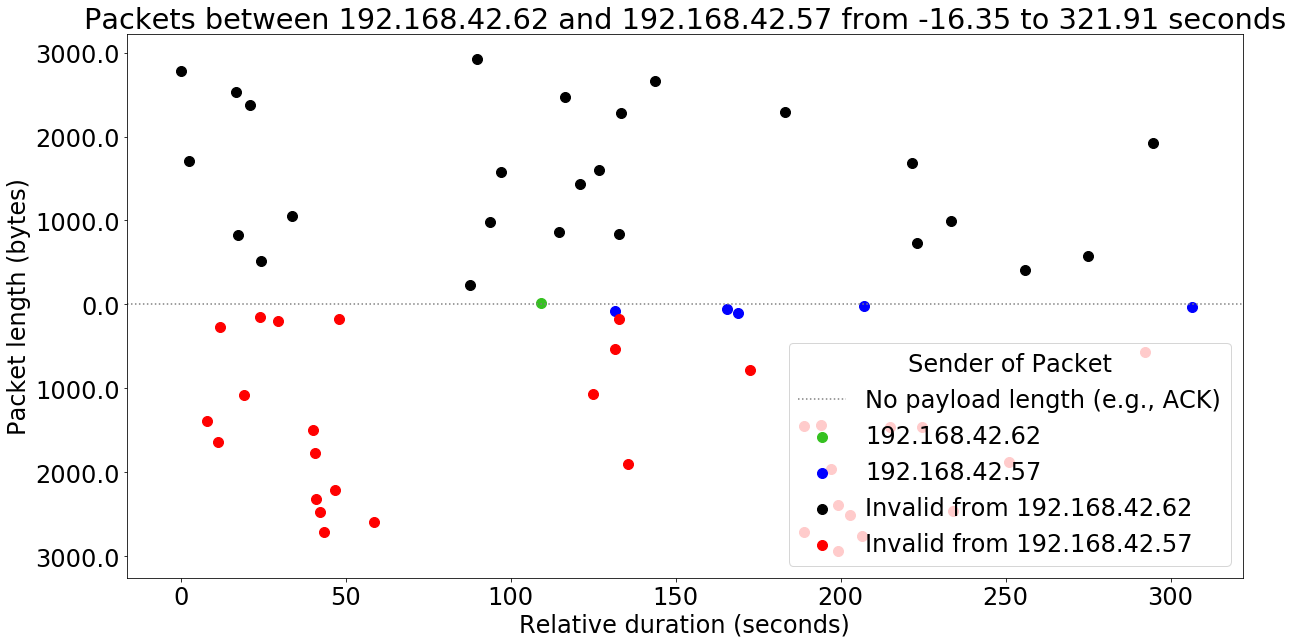

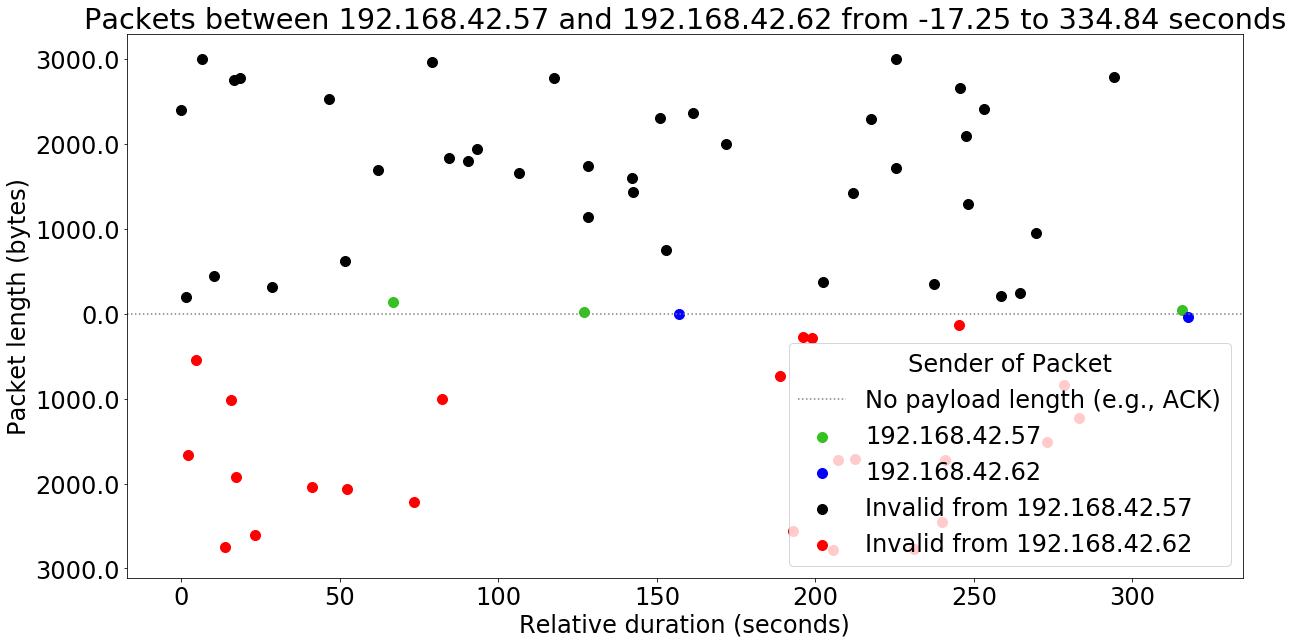

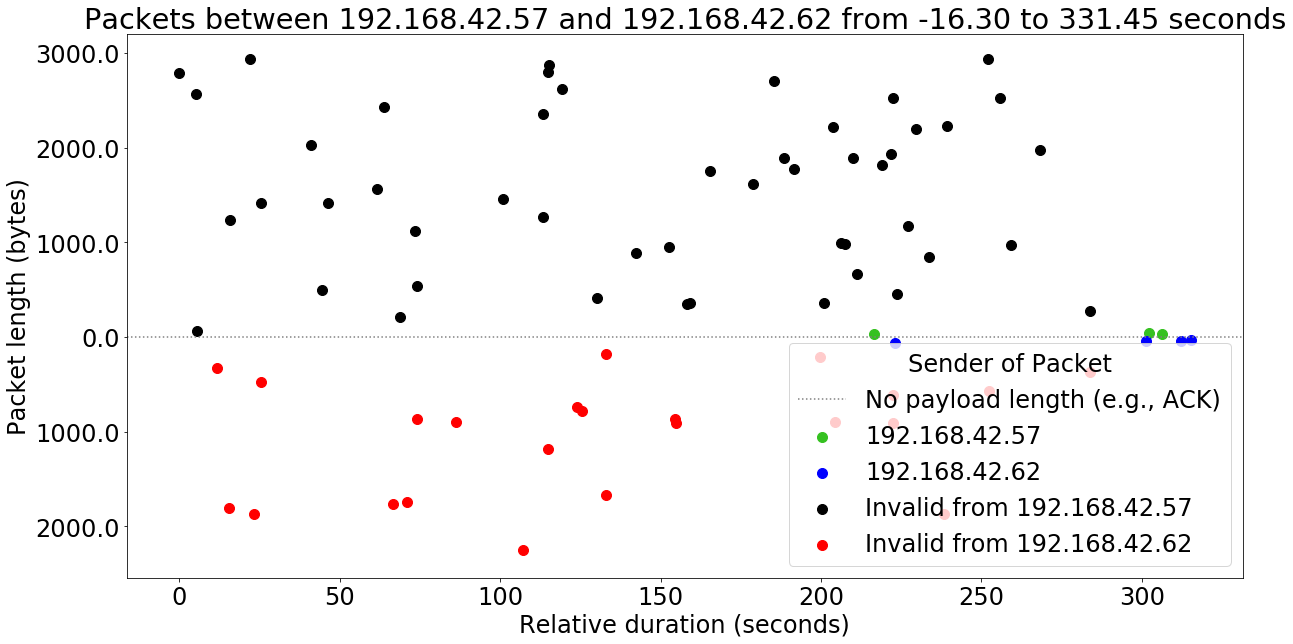

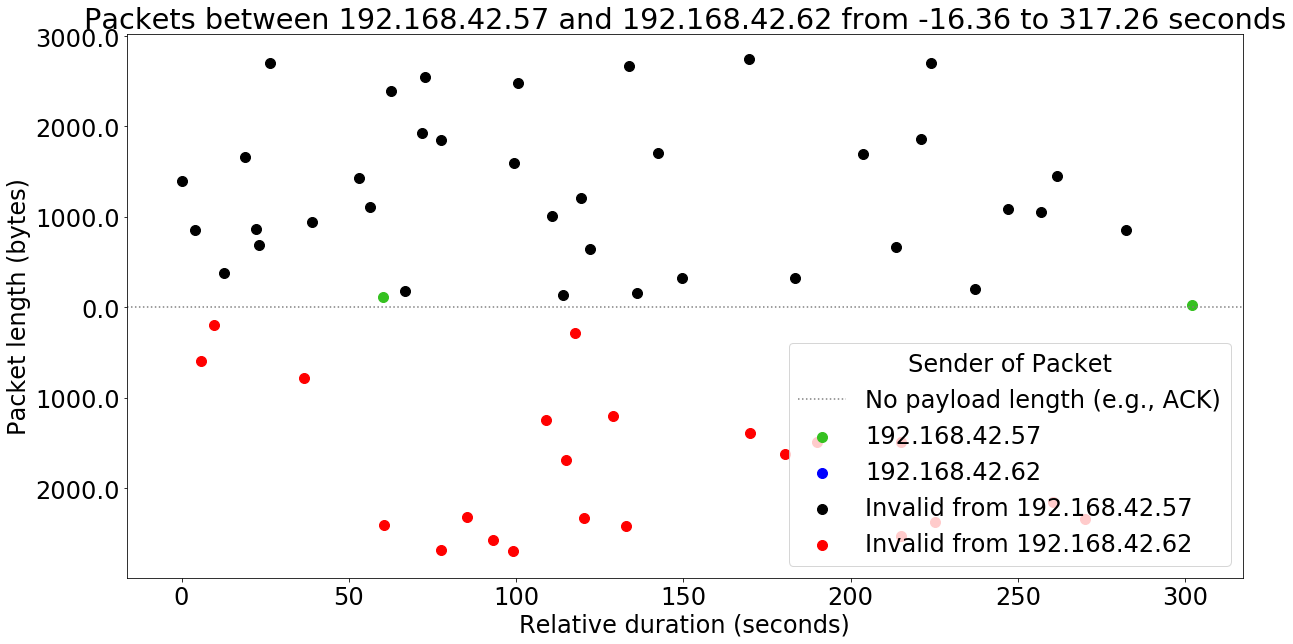

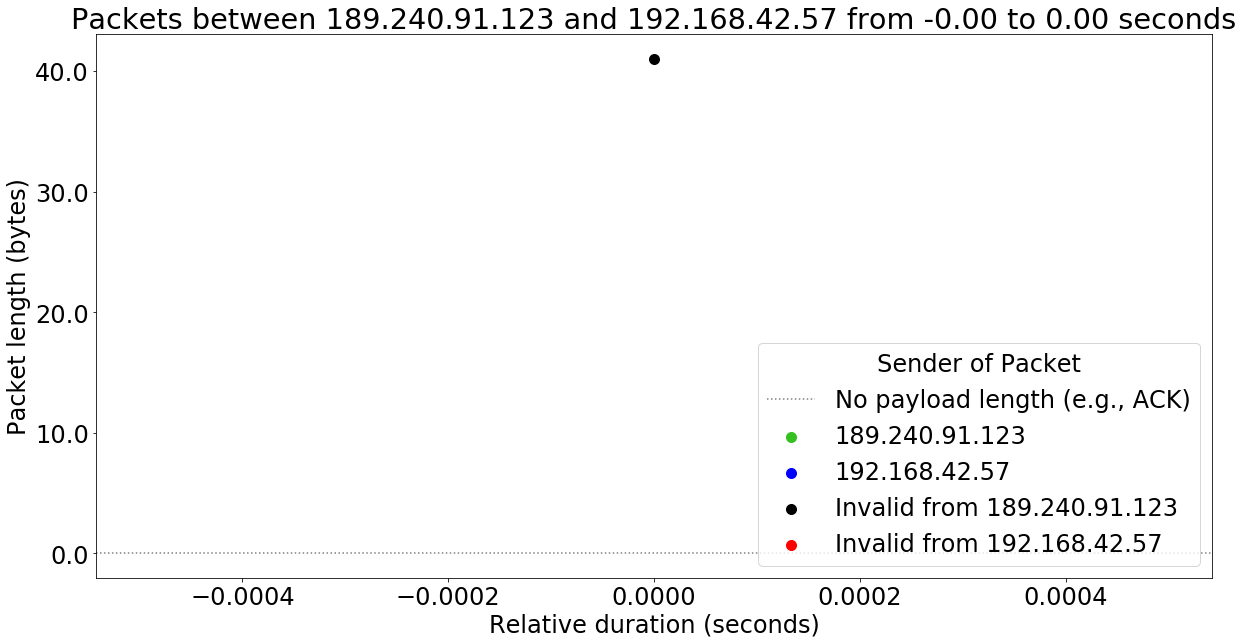

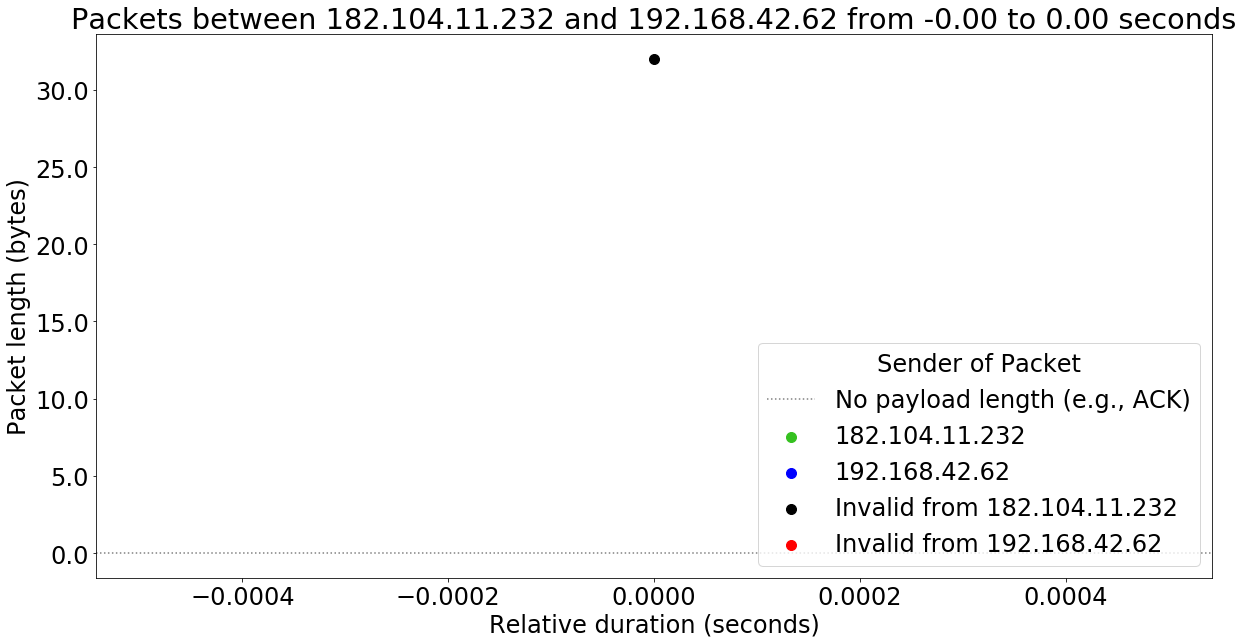

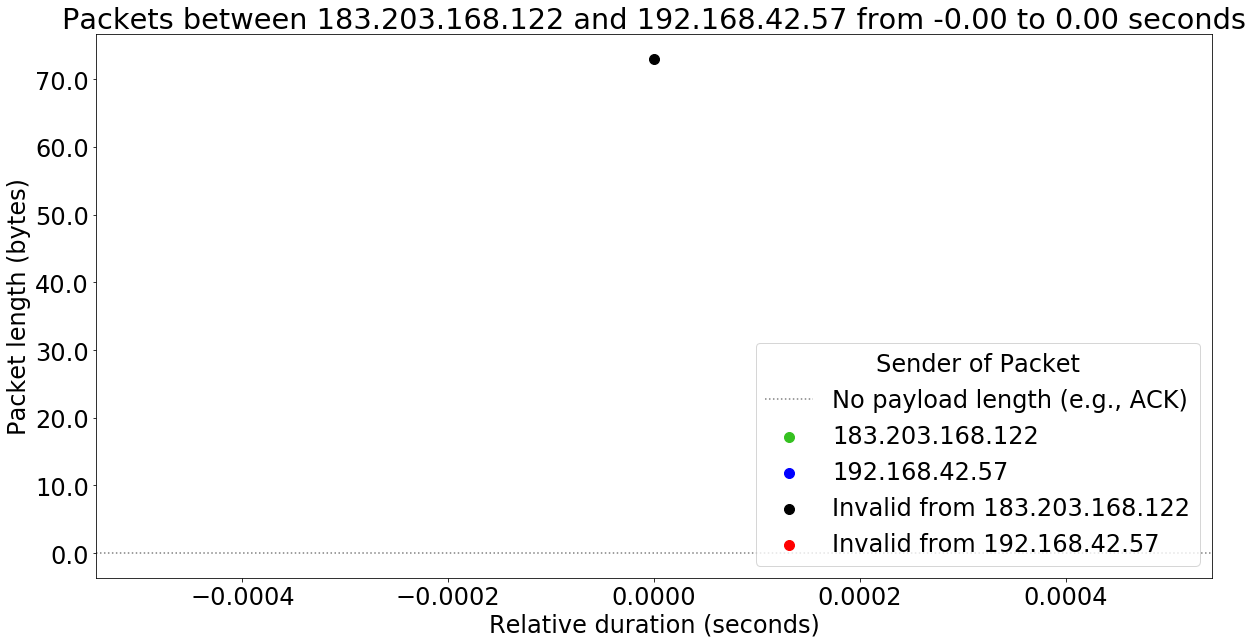

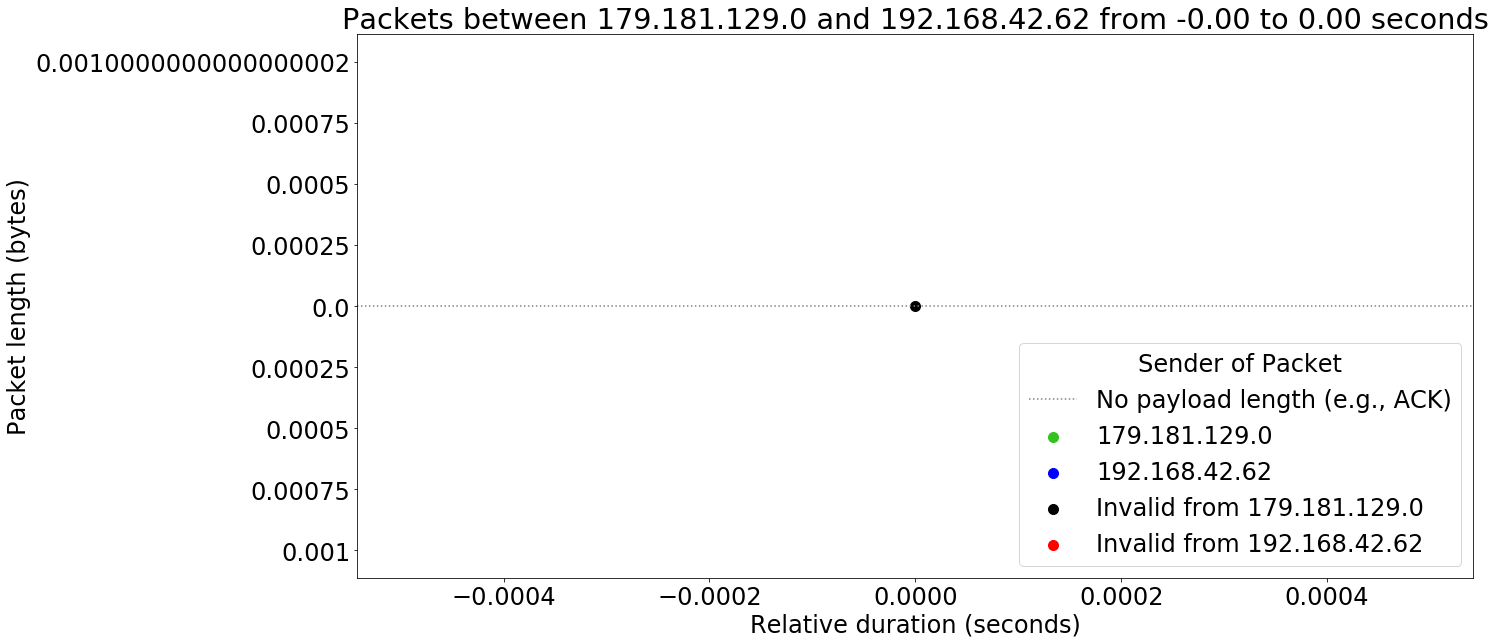

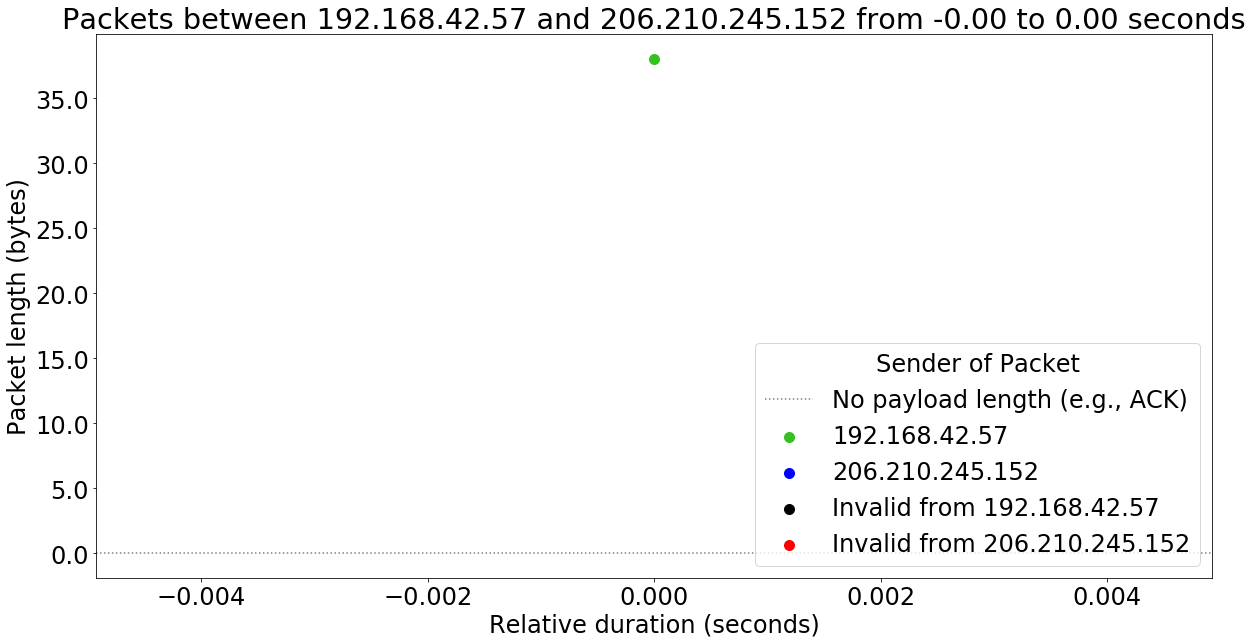

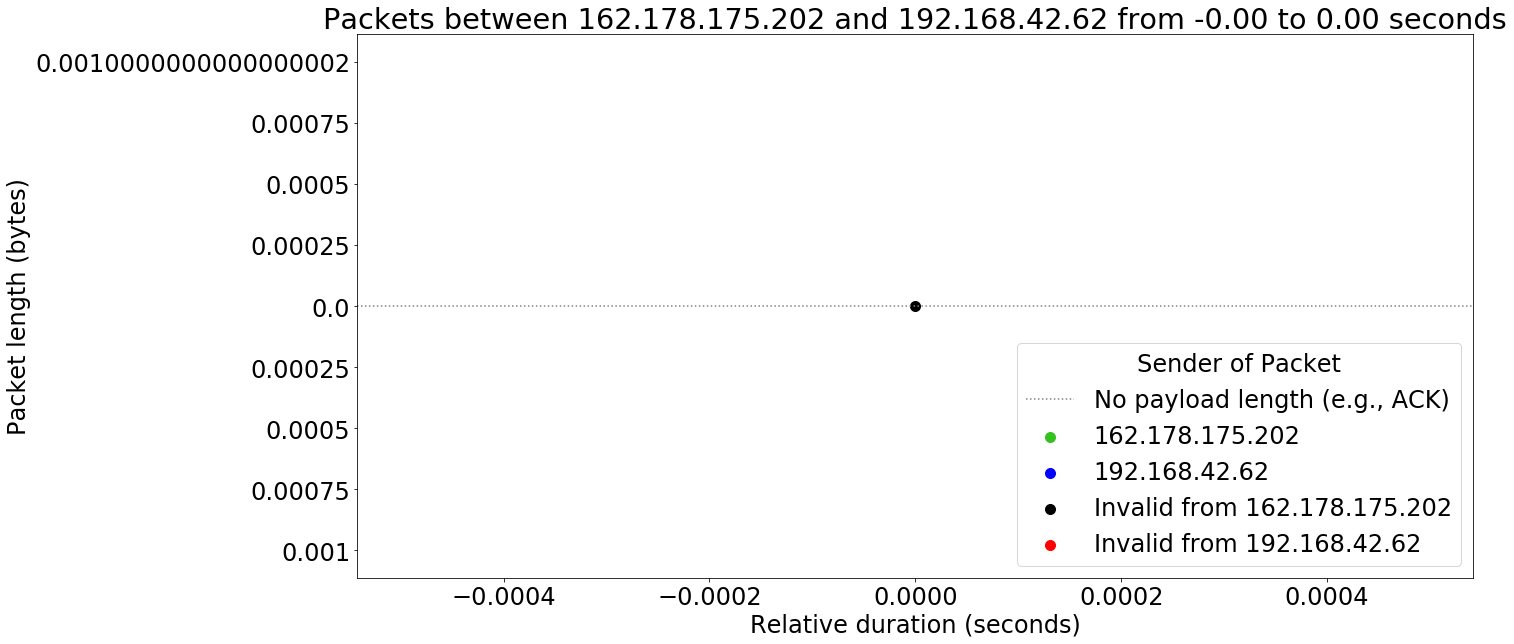

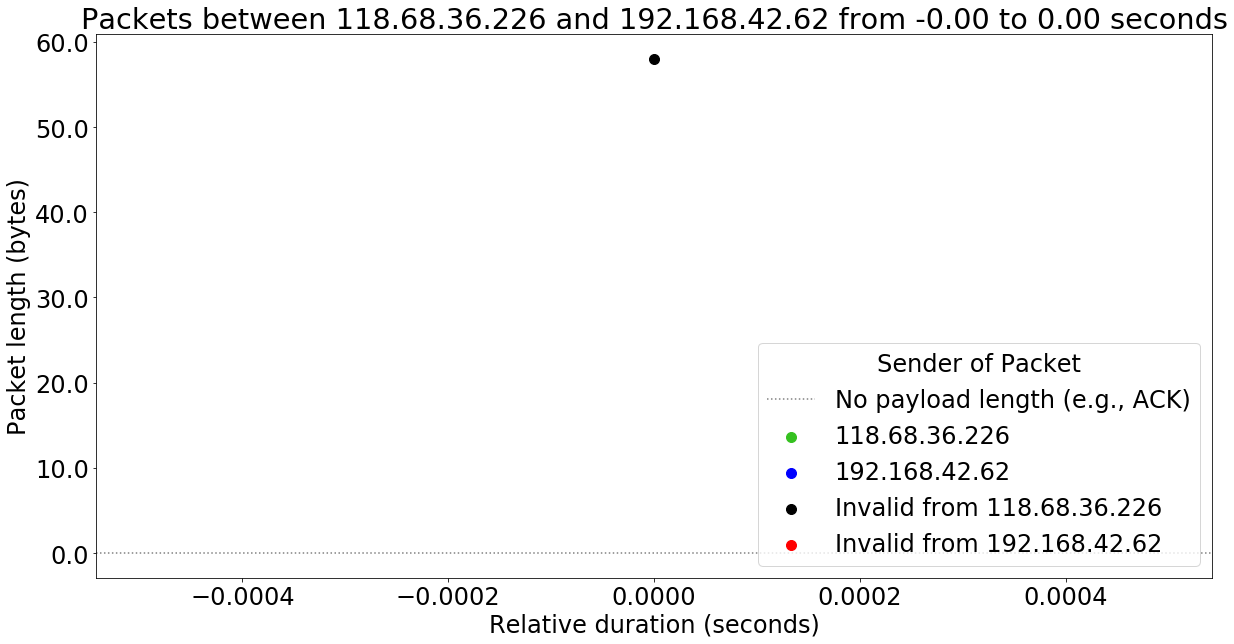

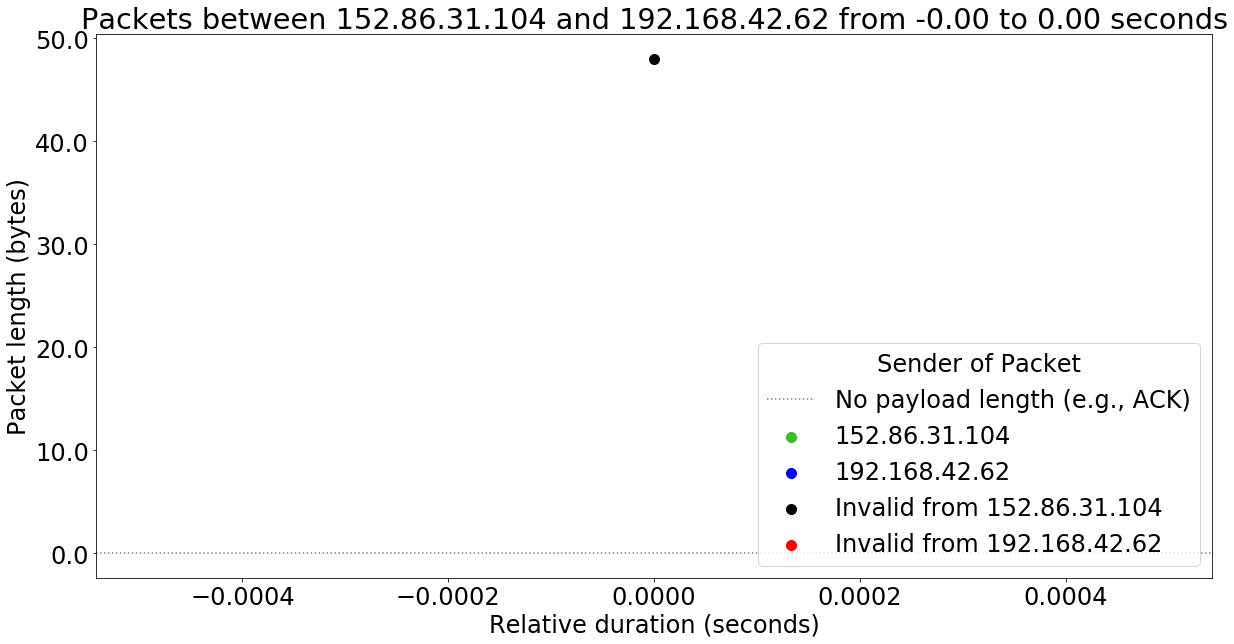

In [15]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)